In [1]:
#Matthew Scott
#Credit card Data Analytics, classification, prediction of Customer trends
#https://www.kaggle.com/sakshigoyal7/credit-card-customers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [62]:
df = pd.read_csv('/Users/scott/Desktop/HCL/resources/BankChurners.csv') 
#drop clientnum, clean then drop attrition_flag
X = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
             'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
             'Marital_Status',
             'Customer_Age',
             'Months_on_book',
             'Contacts_Count_12_mon',
             'Education_Level',
             'Dependent_count',
             'Total_Revolving_Bal',
             'Months_Inactive_12_mon', 
             'Avg_Open_To_Buy',
             'Total_Amt_Chng_Q4_Q1',
             'Total_Relationship_Count',
             'Total_Trans_Amt',
             'Total_Ct_Chng_Q4_Q1'],axis=1)

## Cleaning and Preprocessing
Non current customers were filtered out as they are both irrelevant to the current status of the bank,
and contained a number of missing or not reported values.

To ensure order was maintained for Income Categories, they were hardcoded in increasing order.
There are only 527 non-blue credit cards in the cleaned data set, so this category was condensed into a boolean.
Total transaction amounts and counts were condensed into a single attribute: average value of a single transaction

Income labels are manually encoded, since automatic encoders did not maintain an increasing order from one tier to the next


Finally, the new label attributes are stored as integers and their source attributes dropped

In [63]:
X = X[X['Attrition_Flag'] == 'Existing Customer']
X = X.drop(['Attrition_Flag'],axis=1)
X = X[X['Income_Category'] != 'Unknown']

X['Is_Male'] = X['Gender']
X.loc[X['Gender'] == 'M', 'Is_Male'] = 1
X.loc[X['Is_Male'] != 1, 'Is_Male'] = 0

X['Is_Premium'] = X['Card_Category']
X.loc[X['Card_Category'] == 'Blue', 'Is_Premium'] = 0
X.loc[X['Is_Premium'] != 0, 'Is_Premium'] = 1

X['Income_Tier'] = X['Income_Category']
X.loc[X['Income_Category'] == 'Less than $40K', 'Income_Tier'] = 0
X.loc[X['Income_Category'] == '$40K - $60K', 'Income_Tier'] = 1
X.loc[X['Income_Category'] == '$60K - $80K', 'Income_Tier'] = 2
X.loc[X['Income_Category'] == '$80K - $120K', 'Income_Tier'] = 3
X.loc[X['Income_Category'] == '$120K +', 'Income_Tier'] = 4

X = X.astype({'Is_Premium': 'int64', 'Income_Tier':'int64', 'Is_Male':'int64'})

ids = X['CLIENTNUM']

#drop card_category
X = X.drop(['Income_Category', 'Card_Category', 'Gender', 'CLIENTNUM'], axis=1)

#### Scaling
Scaling the data is important to eliminate differences in magnitudes between attributes. The PCA analysis below shows the amount of variance in the dataset captured by individual attributes. Without scaling, credit limit accounts for virtually all of the variance in the data

In [64]:
scaler1 = MinMaxScaler()
cols = X.columns
X_scaled = pd.DataFrame(scaler1.fit_transform(X))
X_scaled.columns = cols

In [5]:
pca1 = PCA()
pca1.fit(X)
for i in range(len(pca1.explained_variance_ratio_)):
    print(X.columns[i],':',pca1.explained_variance_ratio_[i])

Credit_Limit : 0.9999935416701877
Total_Trans_Ct : 6.441009379423844e-06
Avg_Utilization_Ratio : 1.5045592961846847e-08
Is_Male : 1.1185630683452522e-09
Is_Premium : 6.285646970463728e-10
Income_Tier : 5.277119518287331e-10


In [6]:
pca2 = PCA()
pca2.fit(X_scaled)
for i in range(len(pca2.explained_variance_ratio_)):
    print(X_scaled.columns[i],':',pca2.explained_variance_ratio_[i])

Credit_Limit : 0.606814518623421
Total_Trans_Ct : 0.16717474951277694
Avg_Utilization_Ratio : 0.08319229856313456
Is_Male : 0.062590187675447
Is_Premium : 0.050402422282040685
Income_Tier : 0.029825823343179583


## Clustering
Two algorithms were considered: the classic K-Means algo, and the more sophisticated DBScan. The thought process behind each is shown below, and each concludes with label encodings being stored in the dataframe


#### K-Means
The graph below shows the impact that adding additional clusters to K-Means has on the sum of squares within each cluster. The elbow method reveals a crook in the chart, a point beyond which adding clusters does not improve silhouette scores, a popular performance metric for clustering. Below the chart, silhouette scores are generated to prove what the graph shows: beyond the crook at n_clusters = 2, scores decrease despite the added complexity.

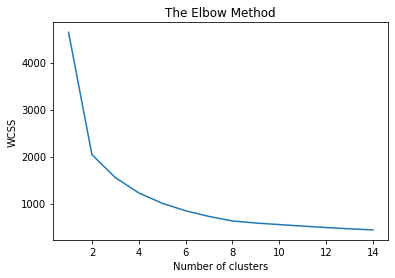

In [7]:
wcss = [] #Within cluster sum of squares
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) #Initialising 
    kmeans.fit(X_scaled) #Fitting on scaled features
    wcss.append(kmeans.inertia_) #Appending the wcss to the blank list
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

In [8]:
for n_clusters in range(2,6):
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("for ", n_clusters," the avg score is ", silhouette_avg)

for  2  the avg score is  0.5281931600344817
for  3  the avg score is  0.4652445010878736
for  4  the avg score is  0.4523857691080763
for  5  the avg score is  0.3684419598336032


In [65]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
X['Kmeans_Labels'] = y_kmeans
kmeans_score= silhouette_score(X_scaled,y_kmeans)
kmeans_score

0.5281931600344817

#### DBScan
The graph below shows distances between a point and its n nearest neighbors (in this case n = 4). DBScan uses a distance metric called eps to determine how it will cluster points. To clarify, a point may join a cluster if it has at least n nearest neighbors that are closer than the eps value. The number of clusters are not fixed, a feature that differentiates DBScan from its counterpart above.

Below the graph, scores for various esp values are generated, as well as the number of clusters the algorithm decides to use for each value.

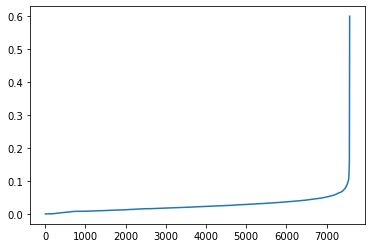

In [10]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [11]:
ranges = [.1,.2,.3,.4,.5,.6]
for i in ranges:
    print(i)
    db = DBSCAN(eps=i, min_samples=5).fit(X_scaled)
    labels = db.labels_
    print("Number of labels: ", len(set(labels)))
    silhouette_avg = silhouette_score(X_scaled,labels)
    print("score is ", silhouette_avg)

0.1
Number of labels:  25
score is  0.052253619098798165
0.2
Number of labels:  16
score is  0.14434009378785012
0.3
Number of labels:  5
score is  0.5239967626020163
0.4
Number of labels:  5
score is  0.5236683644389455
0.5
Number of labels:  5
score is  0.5236683644389455
0.6
Number of labels:  4
score is  0.5409687972966387


In [66]:
db = DBSCAN(eps=.6, min_samples=5).fit(X_scaled)
labels = db.labels_
X['DBSCAN_Labels'] = labels
#X['ID'] = ids

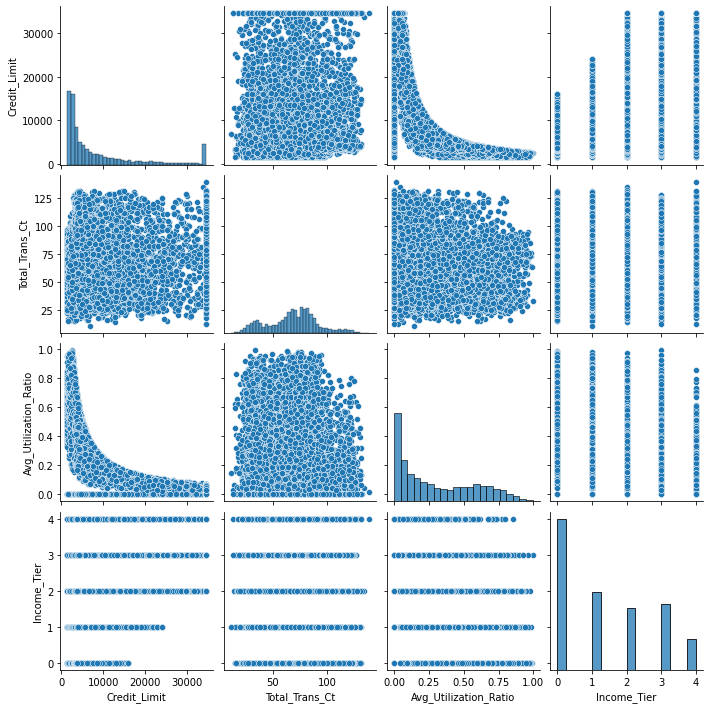

In [10]:
sns.pairplot(X.drop(['Is_Premium', 'Is_Male'], axis=1))

## Data Selection
Values were included in the baseline based on either their percieved usefulness. However, as box plots were developed, it 
became clear that certain attributes were not being sufficiently differentiated by clustering. As an experiment, various attributes were added to and removed from the training set. The table below shows how scores increased and decreased with the presence of certain attributes.

Baseline dataset is Customer_Age, Months_on_book, Total_Relationship_Count, Contacts_Count_12_mon, Credit_Limit, Total_Revolving_Bal, Avg_Utilization_Ratio, Is_Premium, Income_Tier, Avg_Trans_Value

| Item        | Kmeans Score | DBSCAN Score |
| ----------- | -----------  |----------- |
| Baseline      | 0.2188        | 0.3137 |
| With Is_Male   | 0.3571         | 0.3386 |
| With Marital_Labels   | 0.3236 | 0.3011 |
| With Education Level   | 0.3048 | 0.2824 |
| Without Avg Trans Value| 0.3103 | 0.2923 |
| Without Months On Book | 0.3712 | 0.3602 |
| Without Customer Age   | 0.3856 | 0.3769 |
| Without Contacts in last 12 months | 0.4117 | 0.4073 |
| Without Total Relationship Count | 0.5399 | 0.5556 |

## Analysis
Visualizations and summary statistics for clusters are displayed below.

First, a role call. Counting observations reveals two distinct clusters of clusters have formed: 0/1 have thousands customers apiece, while 2/3 merely have hundreds

In [13]:
X.drop('Kmeans_Labels',axis=1).groupby('DBSCAN_Labels').count()

,Credit_Limit,Total_Trans_Ct,Avg_Utilization_Ratio,Is_Male,Is_Premium,Income_Tier
DBSCAN_Labels,,,,,,
0,3661,3661,3661,3661,3661,3661
1,3387,3387,3387,3387,3387,3387
2,364,364,364,364,364,364
3,163,163,163,163,163,163


Examining summary statistics reveals why. As mentioned earlier, there were 527 premium cards in the filtered dataset, the exact number of observations between clusters 2 and 3. As shown below, the Is_Premium attribute is used as a key divider between clusters 0/1 and 2/3.

In [14]:
X.drop('Kmeans_Labels',axis=1).groupby('DBSCAN_Labels').mean()

,Credit_Limit,Total_Trans_Ct,Avg_Utilization_Ratio,Is_Male,Is_Premium,Income_Tier
DBSCAN_Labels,,,,,,
0,10935.809915,64.772193,0.232442,1.0,0.0,2.318492
1,3523.067021,70.570121,0.418633,0.0,0.0,0.236197
2,29740.206044,80.030220,0.049223,1.0,1.0,2.450549
3,14525.699387,79.865031,0.093730,0.0,1.0,0.294479


Another point to note is the behavioral similarities between the 'higher' and 'lower' label within the premium and non premium clusters. The key differentiator is the Male/Female classification (as shown by the summary statistics above), but other similarities exist as well: both forms of an inverse relationship between credit limit and utilization ratio, where lower credit limits makes it easier to use up a significant portion, and low credit individuals occupying a lower income tier. These results are visualized below to emphasize this point.

To summarize: within the premium/non premium clusters, there is an all-male cluster with higher income and credit limits and lower utilization than the all-female remainder of the cluster.

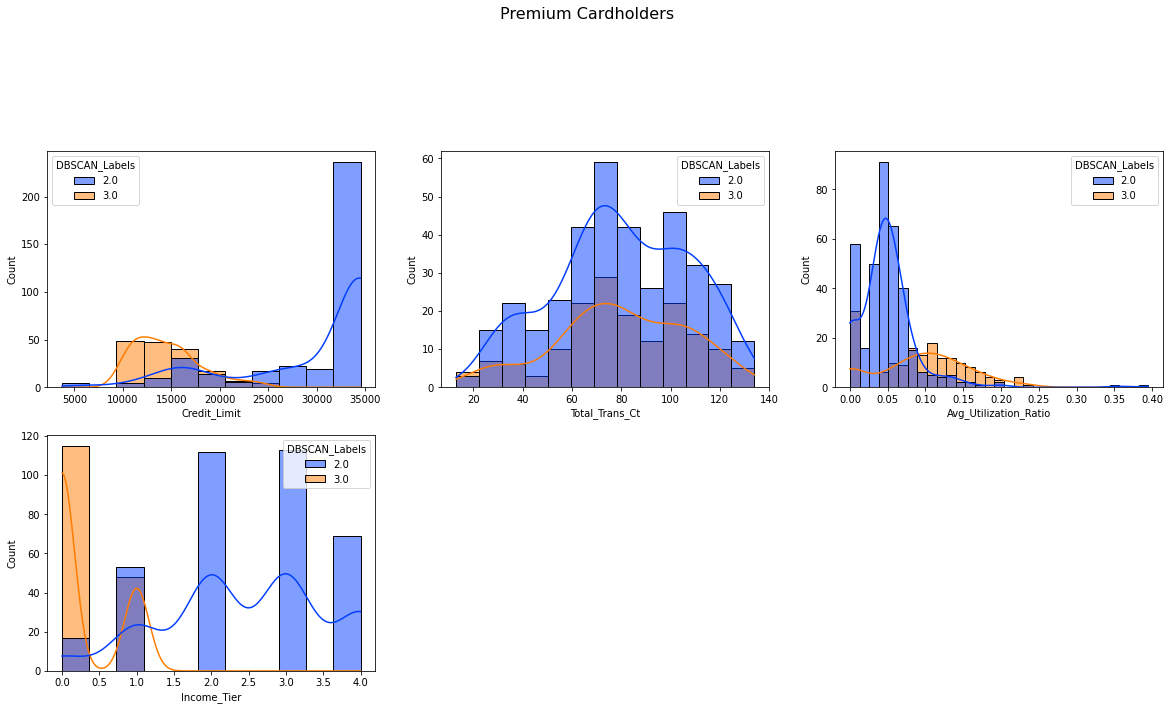

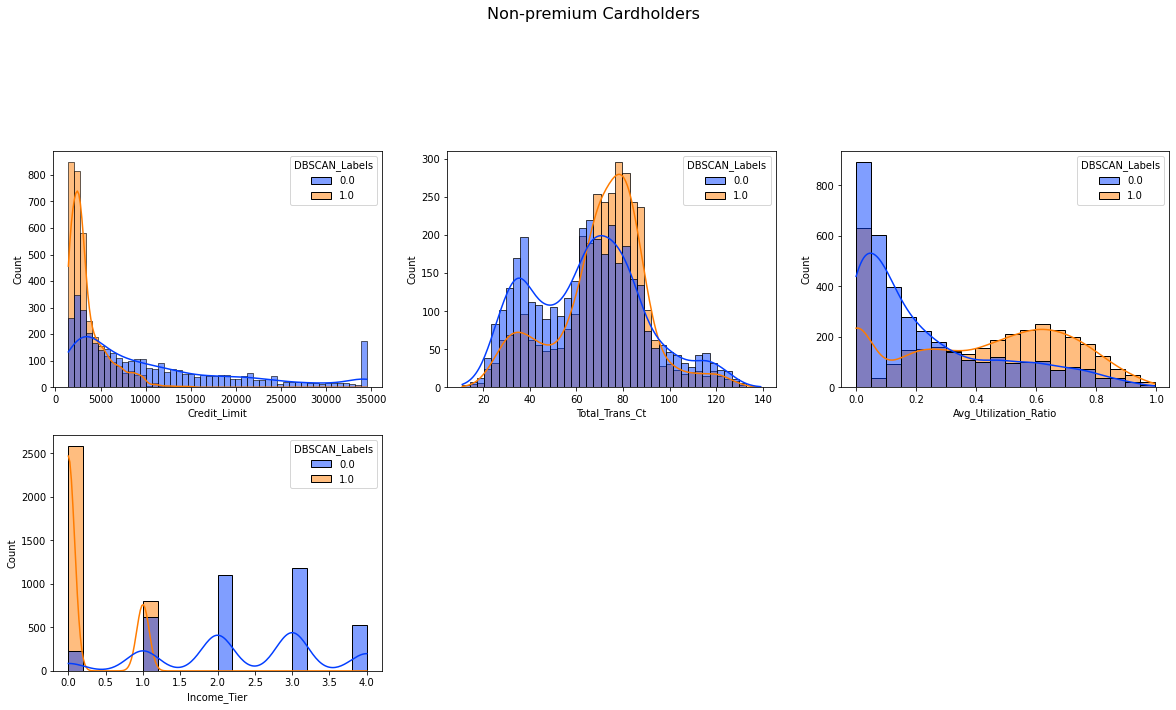

In [15]:
i=1
plt.figure(figsize=(20,20))
for j in X.drop(['Kmeans_Labels','DBSCAN_Labels','Is_Premium', 'Is_Male'], axis=1).columns:
    plt.subplot(4,3,i)
    plt.suptitle('Premium Cardholders', fontsize=16)
    sns.histplot(data=X.drop(X[X.DBSCAN_Labels<2].index),x=X[j],kde=True,hue='DBSCAN_Labels',palette='bright')
    i+=1
    
i=1
plt.figure(figsize=(20,20))
for j in X.drop(['Kmeans_Labels','DBSCAN_Labels','Is_Premium', 'Is_Male'], axis=1).columns:
    plt.subplot(4,3,i)
    plt.suptitle('Non-premium Cardholders', fontsize=16)
    sns.histplot(data=X.drop(X[X.DBSCAN_Labels>=2].index),x=X[j],kde=True,hue='DBSCAN_Labels',palette='bright')
    i+=1

To further emphasize the importance of DBSCAN in capturing irregular cluster shapes in the data, below are summary statistics for the KMeans clusters. The optimized 2 cluster solution differentiates based on gender but fails to differentiate premium card holders, instead treating them as outliers. As shown above, when card types are accounted for, a different view of the data is revealed: although premium cardholders have significantly different mean statistics than nonpremium cardholders (see income tiers), both subgroups possess similar patterns.

In [16]:
X.drop('DBSCAN_Labels',axis=1).groupby('Kmeans_Labels').mean()

,Credit_Limit,Total_Trans_Ct,Avg_Utilization_Ratio,Is_Male,Is_Premium,Income_Tier
Kmeans_Labels,,,,,,
0,12636.381391,66.152050,0.215873,1.0,0.090435,2.330435
1,4028.258310,70.996901,0.403715,0.0,0.045915,0.238873


Such a fact may be useful to companies who are implementing a strategy based on a customer's position within the distribution of one of the attributes: relatively speaking, premium and nonpremium customers have similar characteristics, just at different levels.

To illustrate the levels point, assume the company wants to increase a certain female's utilization ratio of .15 to the mean by giving her high-value cashback deals. They believe her usage is not in line with other females. According to Kmeans, that value is ~.404. However, according to DBSCAN, that ratio may be far, far less: only .093 for premium card females. So depending on her card status, she could be either above or below the mean utilization ratio, a fact that, for this strategy, determines whether or not such a strategy is productive or wasteful.

If such a strategy did take card status into account, however, then its logic could be implemented generally: other than customers with zero utilization, there is a similar distribution shape present that suggests that a relative implementation that is effective for one card status will be effective for the other as well.

## Use Case: Recommendations
A significant portion of revenue in the credit card industry comes from interchange fees on premium cards. That is, for each purchase made, the store that accepts the card pays a percentage to the card company, a percentage that is significantly higher for premium cards than nonpremium ones

Below is a scatterplot comparing the two premium clusters to provide a sense of how clustering performed with separating the data

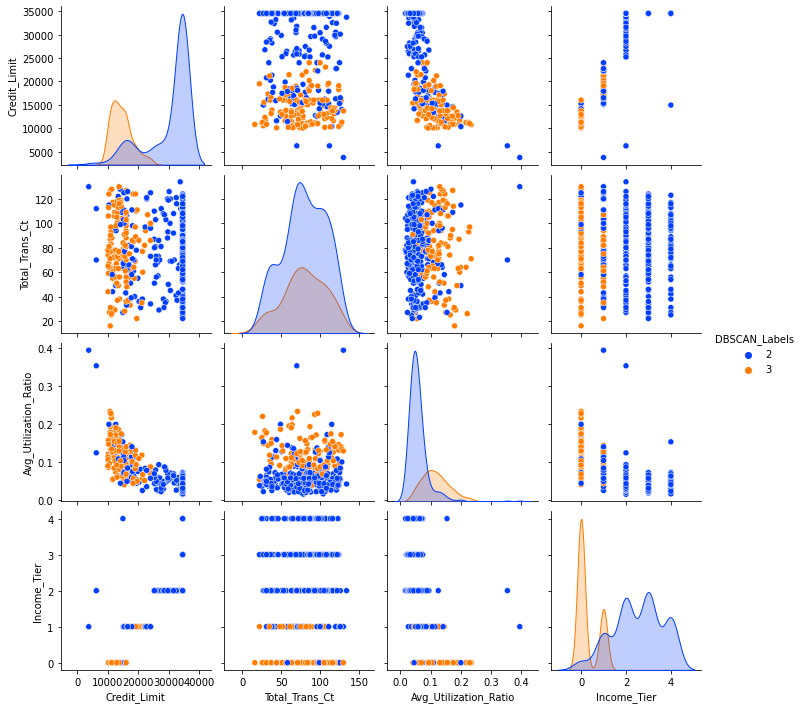

In [17]:
sns.pairplot(X[(X.DBSCAN_Labels>1)&(X.Avg_Utilization_Ratio>0)].drop(['Kmeans_Labels','Is_Premium', 'Is_Male'], axis=1),hue='DBSCAN_Labels',palette='bright')

After some research on credit card companies, it was decided that a combination of utilization ratio and transaction count would be important in determining which individuals to select. Shown below are the male/non premium cluster and female/non premium cluster, respectively. Within this cluster, income tier is negatively correlated with utilization (-.28) and just negligibly correlated with transaction count (.003). Therefore, there is only a small group of individuals who are high income, have high utilization, and a large number of transactions.

Such individuals have a high potential for providing a large amount of revenue to the company. The bars drawn are each 1 standard deviation above the mean for utilization and transaction count. Such a selective range limits the number of high income individuals who will be included, but simultaneously ensures that those selected are making the most of their cards and thus will be valuable to creating revenue.

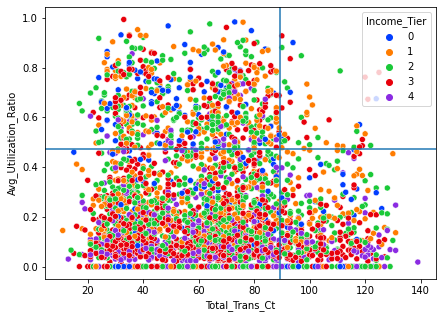

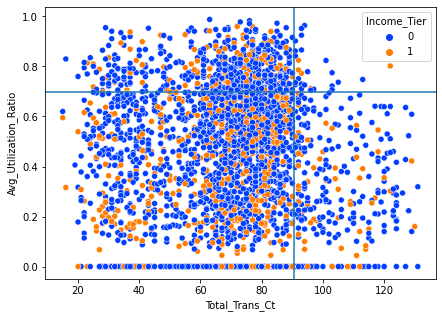

In [18]:
for label in [0,1]:
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=X.drop(X[(X.DBSCAN_Labels!=label)].index),y='Avg_Utilization_Ratio',x='Total_Trans_Ct',hue='Income_Tier',palette='bright')
    plt.axvline(X[X.DBSCAN_Labels == label].Total_Trans_Ct.mean()+X[X.DBSCAN_Labels == label].Total_Trans_Ct.std(), 0)
    plt.axhline(X[X.DBSCAN_Labels == label].Avg_Utilization_Ratio.mean()+X[X.DBSCAN_Labels == label].Avg_Utilization_Ratio.std(), 0)

Within the premium clusters, those who are of the highest interest are those whose usage is low despite having a low credit limit. These two attributes are negatively correlated (-.46 and -.33 for each cluster), which suggests that those with low use and low credit in theory have the greatest potential to have their usage raised, which in turn brings in more revenue for the company.

Shown below are the two premium clusters, male then female, with mean utilization and one standard deviation below the mean credit limit being charted to reveal this subsection of potential individuals.

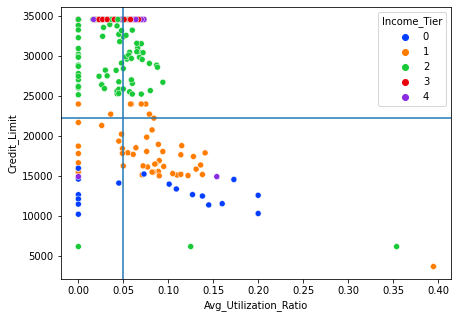

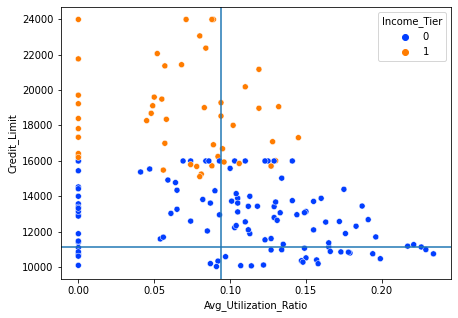

In [19]:
for label in [2,3]:
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=X.drop(X[(X.DBSCAN_Labels!=label)].index),y='Credit_Limit',x='Avg_Utilization_Ratio',hue='Income_Tier',palette='bright')
    #cluster 2 mean utilization, mean - stddev credit limit
    plt.axvline(X[X.DBSCAN_Labels == label].Avg_Utilization_Ratio.mean(), 0)
    plt.axhline(X[X.DBSCAN_Labels == label].Credit_Limit.mean()-X[X.DBSCAN_Labels == label].Credit_Limit.std(), 0)

Finally, to assess the effect these restrictions had on selecting individuals, the number of individuals from each cluster that qualify are printed. There are 16 premium and 19 non premium individuals who qualify based on the above qualifications.

In [20]:
for i in [2,3]:
    tmp_df = X[X.DBSCAN_Labels==i]
    print("label:",i,":")
    print(len(tmp_df[(tmp_df.Total_Trans_Ct < tmp_df.Total_Trans_Ct.mean()-tmp_df.Total_Trans_Ct.std()) & (tmp_df.Credit_Limit < tmp_df.Credit_Limit.mean()-tmp_df.Credit_Limit.std())]))

for i in [0,1]:
    tmp_df = X[X.DBSCAN_Labels==i]
    print("label:",i,":")
    print(len(tmp_df[(tmp_df.Income_Tier > tmp_df.Income_Tier.mean()) & (tmp_df.Total_Trans_Ct > tmp_df.Total_Trans_Ct.mean()+tmp_df.Total_Trans_Ct.std()) & (tmp_df.Avg_Utilization_Ratio > tmp_df.Avg_Utilization_Ratio.mean() + tmp_df.Avg_Utilization_Ratio.std())]))
 

label: 2 :
12
label: 3 :
4
label: 0 :
14
label: 1 :
5


## Automation and Implementation
Combining elements from above, element distances are calculated and used to build a range of possible eps values. Since we want the algorithm clustering large portions of the data, it is important that these values are taken on the larger end of existing distances. A number of DBSCAN clusters are ran and results compared to find the best silhouette score and the eps value it corresponds with. 

This takes the manual comparison element out of the equation while allowing the algorithm to dynamically select the best possible esp parameter for itself.

*As a note, using scaled data ensures max distances will be contained, as all scaled attributes range between 0 and 1*

In [67]:
def cluster_builder(X):
    neighbors = NearestNeighbors(n_neighbors=4)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    start = round(math.ceil(distances.mean()*10))/10
    end = round(math.ceil(distances.max()*10))/10

    best_eps,score = 0,0
    for eps_try in np.arange(start,end+.1,.1):
        temp_db = DBSCAN(eps=eps_try, min_samples=5).fit(X_scaled)
        labels = temp_db.labels_
        silhouette_avg = silhouette_score(X_scaled,labels)
        if silhouette_avg > score:
            score = silhouette_avg
            best_eps = eps_try

    db = DBSCAN(eps=best_eps, min_samples=5).fit(X_scaled)

Below are the three functions that identify individuals. The first two locate premium and nonpremium individuals, and the third builds a labeled dataframe with ids and recommendations using the first two functions's outputs. 

In [68]:
def locateLowUsePremium(X):
    customer_output = pd.DataFrame()
    
    premium_labels = [i for i in X.DBSCAN_Labels.unique() if X[X.DBSCAN_Labels==i].Is_Premium.mean() > 0]
    
    #isolate premium labels
    for i in premium_labels:
        tmp_df = X[X.DBSCAN_Labels==i]
        customer_output = pd.concat([customer_output,tmp_df[(tmp_df.Avg_Utilization_Ratio < tmp_df.Avg_Utilization_Ratio.mean()) & (tmp_df.Credit_Limit < tmp_df.Credit_Limit.mean()-tmp_df.Credit_Limit.std())][['ID','DBSCAN_Labels']]])
    return(customer_output)

In [69]:
def locatePremiumCandidates(X):
    customer_output = pd.DataFrame()
    
    nonpremium_labels = [i for i in X.DBSCAN_Labels.unique() if X[X.DBSCAN_Labels==i].Is_Premium.mean() < 1]
    
    #isolate nonpremium labels
    for i in nonpremium_labels:
        tmp_df = X[X.DBSCAN_Labels==i]
        customer_output = pd.concat([customer_output,tmp_df[(tmp_df.Income_Tier > tmp_df.Income_Tier.mean()) & (tmp_df.Total_Trans_Ct > tmp_df.Total_Trans_Ct.mean()+tmp_df.Total_Trans_Ct.std()) & (tmp_df.Avg_Utilization_Ratio > tmp_df.Avg_Utilization_Ratio.mean() + tmp_df.Avg_Utilization_Ratio.std())][['ID','DBSCAN_Labels']]])
    return(customer_output)
 

In [70]:
def buildOutlierDf(X, ids):
    X['ID'] = ids
    X['Recommendation'] = "No Action"
    low_use_df = locateLowUsePremium(X)
    potential_premium_df = locatePremiumCandidates(X)
    
    X['Low_Use'] = X.ID.isin(low_use_df.ID).astype(int)
    X.loc[X['Low_Use'] == 1, 'Recommendation'] = "Cashback Deals"
    
    X['New_Premium'] = X.ID.isin(potential_premium_df.ID).astype(int)
    X.loc[X['New_Premium'] == 1, 'Recommendation'] = "Offer Premium"
    
    X['Income_Label'] = ""
    X.loc[X['Income_Tier'] == 0, 'Income_Label'] = 'Less than $40K'
    X.loc[X['Income_Tier'] == 1, 'Income_Label'] = '$40K - $60K'
    X.loc[X['Income_Tier'] == 2, 'Income_Label'] = '$60K - $80K'
    X.loc[X['Income_Tier'] == 3, 'Income_Label'] = '$80K - $120K'
    X.loc[X['Income_Tier'] == 4, 'Income_Label'] = '$120K +'
    
    X['DBSCAN_Label'] = ""
    X.loc[X['DBSCAN_Labels'] == 0, 'DBSCAN_Label'] = 'Male, Non Premium'
    X.loc[X['DBSCAN_Labels'] == 1, 'DBSCAN_Label'] = 'Female, Non Premium'
    X.loc[X['DBSCAN_Labels'] == 2, 'DBSCAN_Label'] = 'Male, Premium'
    X.loc[X['DBSCAN_Labels'] == 3, 'DBSCAN_Label'] = 'Female, Premium'
    
    output_df = X[['ID','DBSCAN_Label','Income_Label','Recommendation']]
    return output_df

In [73]:
buildOutlierDf(X,ids).Income_Label.value_counts()

Less than $40K    2949
$40K - $60K       1519
$80K - $120K      1293
$60K - $80K       1213
$120K +            601
Name: Income_Label, dtype: int64

In [22]:
output.ID.iloc[1] in output.ID

False

In [ ]:
indicators["LDC"] = indicators["Country"].apply(get_value, y=groupings["..."].tolist(), choice= ["Fragile", "Not Fragile"])